In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

In [14]:
def implied_returns(delta, sigma, w):
    """
Obtain the implied expected returns by reverse engineering the weights
Inputs:
delta: Risk Aversion Coefficient (scalar)
sigma: Variance-Covariance Matrix (N x N) as DataFrame
    w: Portfolio weights (N x 1) as Series
Returns an N x 1 vector of Returns as Series
    """
    ir = delta * sigma.dot(w).squeeze() 
    ir.name = 'Implied Returns'
    return ir

def proportional_prior(sigma, tau, p):
    """
    Returns the He-Litterman simplified Omega
    Inputs:
    sigma: N x N Covariance Matrix as DataFrame
    tau: a scalar
    p: a K x N DataFrame linking Q and Assets
    returns a P x P DataFrame, a Matrix representing Prior Uncertainties
    """
    helit_omega = p.dot(tau * sigma).dot(p.T)
    return pd.DataFrame(np.diag(np.diag(helit_omega.values)),index=p.index, columns=p.index)

from numpy.linalg import inv

def bl(w_prior, sigma_prior, p, q,
                omega=None,
                delta=2.5, tau=.02):
    """
# Computes the posterior expected returns based on 
# the original black litterman reference model
# W.prior must be an N x 1 vector of weights, a Series
# Sigma.prior is an N x N covariance matrix, a DataFrame
# P must be a K x N matrix linking Q and the Assets, a DataFrame
# Q must be an K x 1 vector of views, a Series
# Omega must be a K x K matrix a DataFrame, or None
# if Omega is None, we assume it is
#    proportional to variance of the prior
# delta and tau are scalars
    """
    if omega is None:
        omega = proportional_prior(sigma_prior, tau, p)
    N = w_prior.shape[0]
    K = q.shape[0]
    pi = implied_returns(delta, sigma_prior,  w_prior)
    sigma_prior_scaled = tau * sigma_prior  
    mu_bl = pi + sigma_prior_scaled.dot(p.T).dot(inv(p.dot(sigma_prior_scaled).dot(p.T) + omega).dot(q - p.dot(pi).values))
    sigma_bl = sigma_prior + sigma_prior_scaled - sigma_prior_scaled.dot(p.T).dot(inv(p.dot(sigma_prior_scaled).dot(p.T) + omega)).dot(p).dot(sigma_prior_scaled)
    return (mu_bl, sigma_bl)



In [45]:
port = ['SPY','TLT']
df = yf.download(port, 
                      start='2021-10-14', 
                      end='2022-10-14', 
                      progress=False)
df = pd.DataFrame(df["Adj Close"])
ret = df.pct_change().dropna()
ret

,SPY,TLT
Date,,
2021-10-14,0.016821,0.003715
2021-10-15,0.007616,-0.005827
2021-10-18,0.002961,0.004689
2021-10-19,0.007715,-0.013794
2021-10-20,0.003928,-0.006750
...,...,...
2022-10-07,-0.027894,-0.009708
2022-10-10,-0.007635,-0.015546
2022-10-11,-0.006333,0.004426


In [48]:
cov = ret.cov()
# SPY_w = SPY MCap/(SPY MCap + TLT MCap)
SPY_MCap = 358.23
TLT_MCap = 24.28
SPY_w = SPY_MCap/(SPY_MCap + TLT_MCap)
TLT_w = TLT_MCap/(SPY_MCap + TLT_MCap)

port_mktcap = pd.Series({"SPY":SPY_w,"TLT":TLT_w})
port_mktcap

SPY    0.936525
TLT    0.063475
dtype: float64

In [101]:
ir = pd.DataFrame(implied_returns(delta=1, sigma=cov, w=port_mktcap), index=port_mktcap.index).T
ir, (1+ir["TLT"])**252

(                      SPY       TLT
 Implied Returns  0.000188  0.000006,
 Implied Returns    1.001416
 Name: TLT, dtype: float64)

In [21]:
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

[]

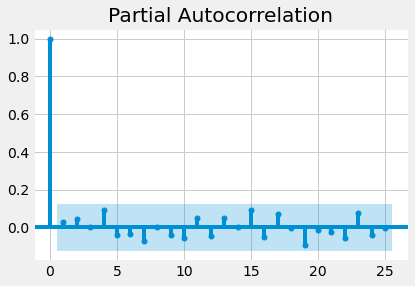

In [87]:
plot_pacf(ret["TLT"]**2)
plt.plot()

In [88]:
model = arch_model(ret["TLT"]*100, p=1 ,q=1)
model_fit = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1139.6339167499264
Iteration:      2,   Func. Count:     17,   Neg. LLF: 758.1061406150933
Iteration:      3,   Func. Count:     24,   Neg. LLF: 400.5218666752616
Iteration:      4,   Func. Count:     30,   Neg. LLF: 401.20559334692905
Iteration:      5,   Func. Count:     36,   Neg. LLF: 401.46488884436513
Iteration:      6,   Func. Count:     42,   Neg. LLF: 400.45183134566133
Iteration:      7,   Func. Count:     48,   Neg. LLF: 401.9500393270296
Iteration:      8,   Func. Count:     54,   Neg. LLF: 400.23687896394136
Iteration:      9,   Func. Count:     60,   Neg. LLF: 399.65786567191964
Iteration:     10,   Func. Count:     65,   Neg. LLF: 399.6271988749077
Iteration:     11,   Func. Count:     70,   Neg. LLF: 399.63090268365556
Iteration:     12,   Func. Count:     76,   Neg. LLF: 399.61733921539394
Iteration:     13,   Func. Count:     81,   Neg. LLF: 399.6172999252682
Iteration:     14,   Func. Count:     86,   Neg. LLF: 39

In [89]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                    TLT   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -399.617
Distribution:                  Normal   AIC:                           807.235
Method:            Maximum Likelihood   BIC:                           821.352
                                        No. Observations:                  252
Date:                Fri, Oct 14 2022   Df Residuals:                      251
Time:                        15:56:20   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            -0.1213  7.401e-02     -1.639      0.101 [ -0.266,2.379e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0114  1.446e-02      0.790      0.429 [-1.692e-02,3.978e-02]
alpha[1]   1.0824e-09  1.795e-02  6.031e-08      1.000 [-3.518e-02,3.518e-02]
beta[1]        0.9943  2.380e-02     41.771      0.000      [  0.948,  1.041]
=============================================================================

Covariance estimator: robust
"""

In [90]:
omega = model_fit.params['omega']
a = model_fit.params['alpha[1]']
b = model_fit.params['beta[1]']

In [92]:
GARCH = (omega) + (a*((1+ret["TLT"].mean())**(252)-1)**2) + (b*(ret["TLT"].std()*(252**0.5))**2)
GARCH,(GARCH/(252**0.5))

(0.04716576269666784, 0.0029711637736207215)

In [42]:
from scipy.stats import norm

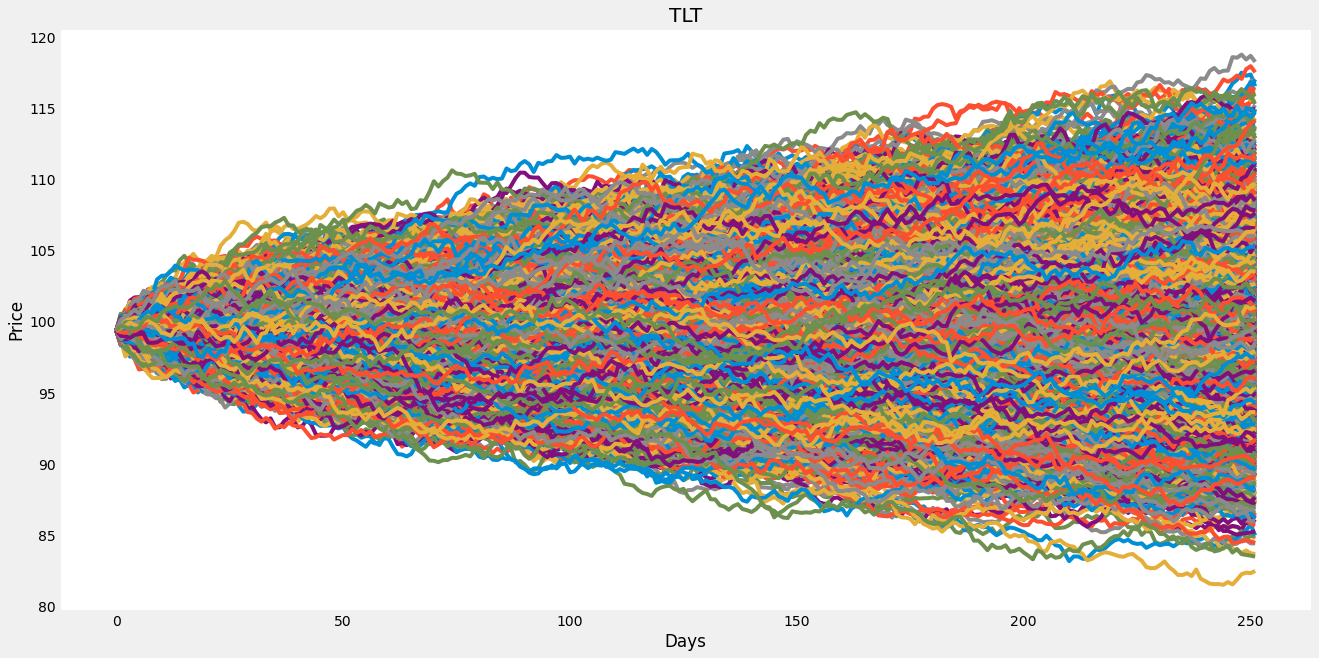

In [93]:
u = ir["TLT"]

var = (GARCH/(252**0.5))**2
drift = u - (0.5 * var)
stdev = (GARCH/(252**0.5))


np.array(drift)
np.array(stdev)

norm.ppf(0.95)

x = np.random.rand(10, 2)
Z = norm.ppf(np.random.rand(10,2))

t_intervals = 252
iterations = 10000

daily_returns = np.exp(np.array(drift) + np.array(stdev) * norm.ppf(np.random.rand(t_intervals, iterations)))

S0 = df["TLT"][-1]

price_list = np.zeros_like(daily_returns)
price_list[0] = S0

for t in range(1, t_intervals):
    price_list[t] = price_list[t - 1] * daily_returns[t]

plt.figure(figsize=(20,10))
plt.plot(price_list)
plt.title('TLT')
plt.xlabel('Days')
plt.ylabel('Price')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.5)
plt.rcParams['axes.facecolor'] = 'white'

In [68]:
pl = price_list[251,]
spy = np.sort(pl)
df_describe = pd.DataFrame(spy)
stat = df_describe.describe()


0    376.243215
Name: 50%, dtype: float64

In [94]:
pl = price_list[251,]
tlt = np.sort(pl)
df_describe = pd.DataFrame(tlt)
stat2 = df_describe.describe()
stat2

,0
count,10000.000000
mean,99.624543
std,4.700171
min,82.516834
25%,96.430161
50%,99.517217
75%,102.783874
max,118.246606


In [85]:
# SPY one y ahead returns

a = stat.T["75%"]/df["SPY"][-1]-1
b = stat.T["50%"]/df["SPY"][-1]-1
c = stat.T["25%"]/df["SPY"][-1]-1

yret_list= [pd.DataFrame(c), pd.DataFrame(b), pd.DataFrame(a)]
comparison = pd.concat(yret_list, axis=1)
comparison.columns =["1_Q","Median", "3_Q" ]
comparison

,1_Q,Median,3_Q
0,-0.096488,0.028071,0.175353


In [110]:
b = stat.T["50%"]/df["SPY"][-1]-1
b

0    0.028071
Name: 50%, dtype: float64

In [95]:
# TLT one y ahead returns

d = stat2.T["75%"]/df["TLT"][-1]-1
e = stat2.T["50%"]/df["TLT"][-1]-1
f = stat2.T["25%"]/df["TLT"][-1]-1

yret_list_tlt= [pd.DataFrame(f), pd.DataFrame(e), pd.DataFrame(d)]
comparison2 = pd.concat(yret_list_tlt, axis=1)
comparison2.columns =["1_Q","Median", "3_Q" ]
comparison2

,1_Q,Median,3_Q
0,-0.02978,0.00128,0.034147


In [96]:
df_w = pd.Series({'SPY': 0.60, 'TLT': 0.40})
df_w

SPY    0.6
TLT    0.4
dtype: float64

In [173]:
one_y_ret = pd.Series({'SPY': b, 'TLT': e})
one_y_ret

SPY    0   0.0281
Name: 50%, dtype: float64
TLT    0   0.0013
Name: 50%, dtype: float64
dtype: object

In [178]:
p = pd.DataFrame([
    {'SPY': 1, 'TLT': 0},
    {'SPY': 0, 'TLT': 1}
    ])

delta = 1

bl_mu, bl_sigma = bl(w_prior=df_w,omega=proportional_prior(cov,1/252, p) , sigma_prior=cov, delta=delta, p=p, q=one_y_ret, tau = 1/252)
bl_mu, bl_sigma*252

(SPY    0   0.0141
 Name: 50%, dtype: float64
 TLT    0   0.0005
 Name: 50%, dtype: float64
 dtype: object,
         SPY     TLT
 SPY  0.0508 -0.0009
 TLT -0.0009  0.0360)

In [168]:
def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)

In [183]:
from scipy.optimize import minimize
def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns

def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    vol = (weights.T @ covmat @ weights)**0.5
    return vol 

def msr(riskfree_rate, er, cov):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.1, 1),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

In [186]:
pd.options.display.float_format = '{:.4f}'.format
opt = pd.DataFrame(msr(0.04, bl_mu, bl_sigma), index=bl_mu.index)
opt.columns = ['MSR_weights']
opt

C:\Users\gbartolovic\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


,MSR_weights
SPY,0.9000
TLT,0.1000


In [193]:
def optimal_weights(n_points, er, cov):
    """
    Returns a list of weights that represent a grid of n_points on the efficient frontier
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights
def plot_ef(n_points, er, cov, style='.-', legend=False, show_cml=False, riskfree_rate=0, show_ew=False, show_gmv=False):
    """
    Plots the multi-asset efficient frontier
    """
    weights = optimal_weights(n_points, er, cov)
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    ax = ef.plot.line(x="Volatility", y="Returns", style=style, legend=legend, figsize=(20,10))
    if show_cml:
        ax.set_xlim(left = 0)
        # get MSR
        w_msr = msr(riskfree_rate, er, cov)
        r_msr = portfolio_return(w_msr, er)
        vol_msr = portfolio_vol(w_msr, cov)
        # add CML
        cml_x = [0, vol_msr]
        cml_y = [riskfree_rate, r_msr]
        ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=10)
    if show_ew:
        n = er.shape[0]
        w_ew = np.repeat(1/n, n)
        r_ew = portfolio_return(w_ew, er)
        vol_ew = portfolio_vol(w_ew, cov)
        # add EW
        ax.plot([vol_ew], [r_ew], color='goldenrod', marker='o', markersize=10)
    if show_gmv:
        w_gmv = gmv(cov)
        r_gmv = portfolio_return(w_gmv, er)
        vol_gmv = portfolio_vol(w_gmv, cov)
        # add EW
        ax.plot([vol_gmv], [r_gmv], color='midnightblue', marker='o', markersize=10)
        
        return ax

In [194]:
plot_ef(20, bl_mu, bl_sigma, show_cml=True, riskfree_rate=0.04, show_ew=True, show_gmv=True)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().